#Reprocessing

In [1]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
import statsmodels.formula.api as smf
import numpy as np


# Create pandas dataframe 
df1 = pd.read_csv('Arrests_and_Strip_Searches_(RBDC-ARR-TBL-001).csv')

# Filter out "U" in the "Sex" column
df2 = df1[df1['Sex'] != 'U']

# Group 17 years and under 
df2['Age_group__at_arrest_'] = df2['Age_group__at_arrest_'].replace('Aged 17 years and younger', 'Aged 17 years and under')
df2['Youth_at_arrest__under_18_years'] = df2['Youth_at_arrest__under_18_years'].replace('Youth (aged 17 and younger)', 'Youth (aged 17 years and under)')

# Save the updated dataset
df2.to_csv('updated_arrests.csv', index=False)

# Group the 65 years and older
df2['Age_group__at_arrest_'] = df2['Age_group__at_arrest_'].replace('Aged 65 years and older', 'Aged 65 and older')

# Save the updated dataset
df2.to_csv('updated_arrests.csv', index=False)

# Set the new dataframe
df = pd.read_csv('updated_arrests.csv')

print(df['Youth_at_arrest__under_18_years'].unique())


<ipython-input-1-693da2eff58a>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Age_group__at_arrest_'] = df2['Age_group__at_arrest_'].replace('Aged 17 years and younger', 'Aged 17 years and under')
<ipython-input-1-693da2eff58a>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Youth_at_arrest__under_18_years'] = df2['Youth_at_arrest__under_18_years'].replace('Youth (aged 17 and younger)', 'Youth (aged 17 years and under)')
<ipython-input-1-693da2eff58a>:26: SettingWithCopyWarning: 
A value is t

['Not a youth' 'Youth (aged 17 years and under)']


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#ANCOVA

In [2]:
# Define the data for the ANCOVA
subset = df[['PersonID', 'StripSearch','Perceived_Race']].dropna()
grouped_data = subset.groupby(['PersonID', 'Perceived_Race']).agg(TotalStripSearches=('StripSearch', 'sum'), TotalArrests=('StripSearch', 'count')).reset_index()

grouped_data = grouped_data.rename(columns={'PersonID_': 'PersonID', 'Perceived_Race_': 'Perceived_Race', 'StripSearch_sum': 'TotalStripSearches', 'StripSearch_count': 'TotalArrests'})

# Sort the data by descending order of TotalStripSearches
grouped_data = grouped_data.sort_values('TotalStripSearches', ascending=False)
grouped_data.head()
print(grouped_data)

       PersonID Perceived_Race  TotalStripSearches  TotalArrests
4213     303892     Indigenous                  13            37
25398    323471          Black                  12            20
40019    337011          White                  12            25
26501    324487          Black                  11            22
6818     306296          White                  10            17
...         ...            ...                 ...           ...
14413    313302          White                   0             1
14414    313303          White                   0             1
14415    313304          Black                   0             1
14416    313305          White                   0             1
40378    337346          White                   0             1

[40379 rows x 4 columns]


In [3]:
# Define the ANCOVA model
model = ols('TotalStripSearches ~ C(Perceived_Race) + TotalArrests', data=grouped_data).fit()

# Print the summary of the model
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:     TotalStripSearches   R-squared:                       0.378
Model:                            OLS   Adj. R-squared:                  0.378
Method:                 Least Squares   F-statistic:                     3067.
Date:                Sun, 16 Apr 2023   Prob (F-statistic):               0.00
Time:                        07:43:00   Log-Likelihood:                -28958.
No. Observations:               40379   AIC:                         5.793e+04
Df Residuals:                   40370   BIC:                         5.801e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

##Assumption check

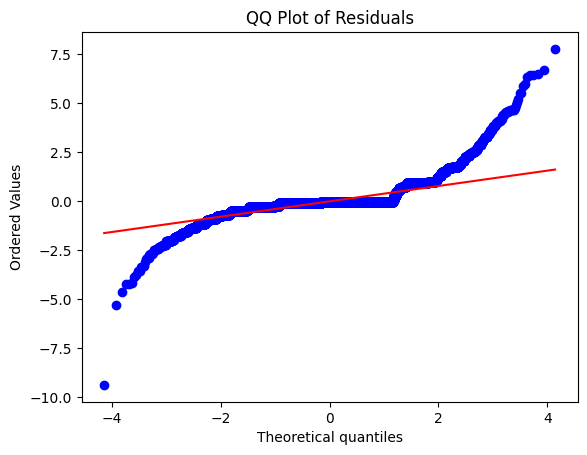

In [4]:
# Perform the ANCOVA
import scipy.stats as stats
import matplotlib.pyplot as plt


# Calculate the residuals
residuals = model.resid

# Generate the QQ plot
fig, ax = plt.subplots()
stats.probplot(residuals, dist="norm", plot=ax)
ax.set_title("QQ Plot of Residuals")
plt.show()


In [5]:
from scipy.stats import levene

# Get the unique perceived race categories
perceived_races = grouped_data['Perceived_Race'].unique()

# Group the TotalStripSearches by Perceived_Race
groups = [grouped_data[grouped_data['Perceived_Race'] == race]['TotalStripSearches'] for race in perceived_races]

# Perform Levene's test for homogeneity of variances
levene_test = levene(*groups)

print("Levene's test statistic:", levene_test.statistic)
print("Levene's test p-value:", levene_test.pvalue)


Levene's test statistic: 69.2840337878076
Levene's test p-value: 5.565333186484268e-100


In [6]:
import statsmodels.api as sm
import statsmodels.formula.api as smf


# Fit an ANCOVA model with an interaction term between Perceived_Race and TotalArrests
ancova_model = smf.ols('TotalStripSearches ~ C(Perceived_Race) * TotalArrests', data=grouped_data).fit()

# Check the interaction effect (p-value) between Perceived_Race and TotalArrests
interaction_p_value = ancova_model.pvalues['C(Perceived_Race)[T.East/Southeast Asian]:TotalArrests']
print(f"Interaction p-value: {interaction_p_value}")

Interaction p-value: 0.0007978599535934704


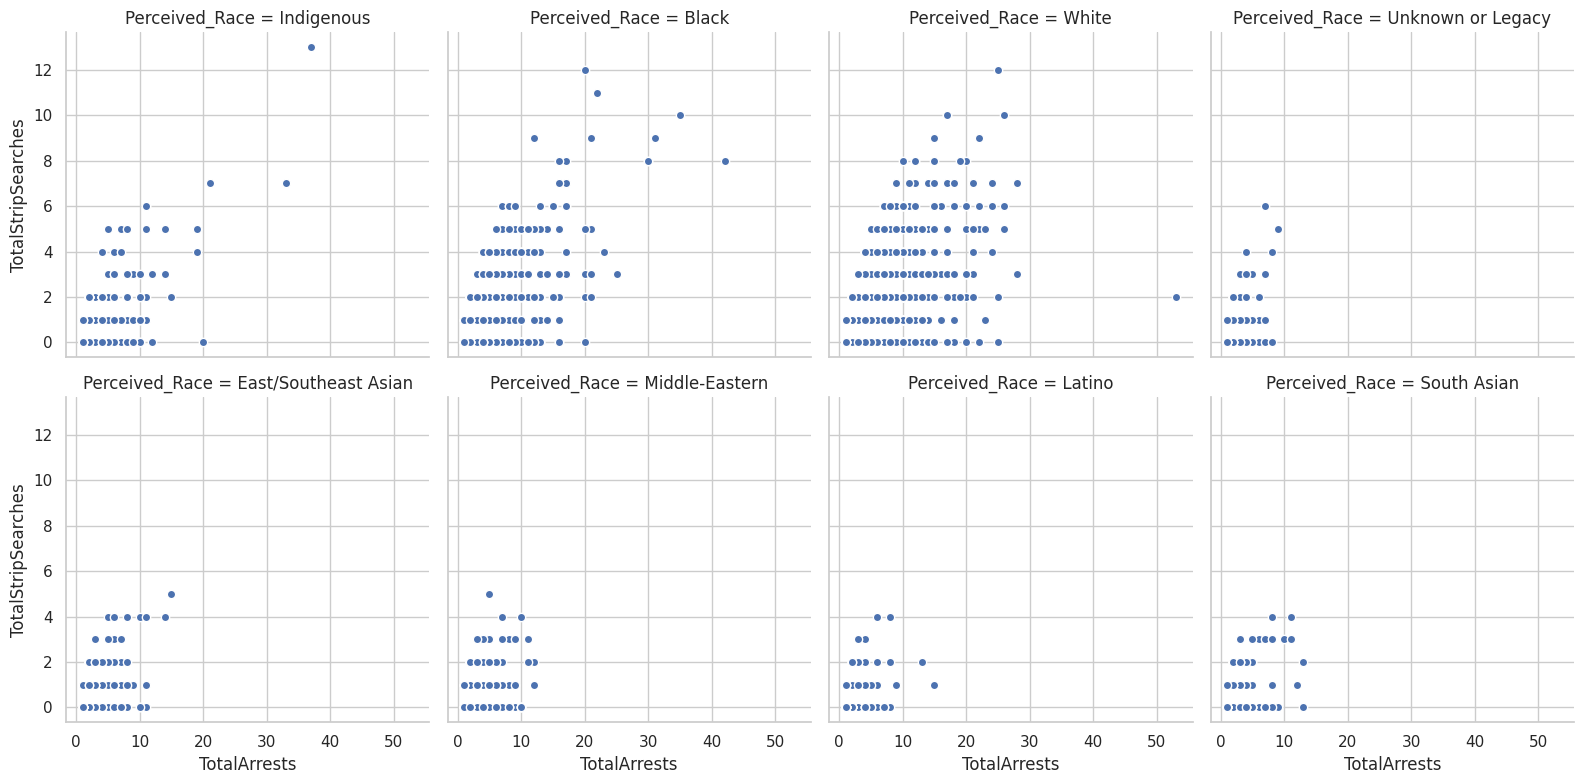

In [7]:

import seaborn as sns

# Create a scatter plot for each perceived race group
sns.set(style="whitegrid")
g = sns.FacetGrid(grouped_data, col="Perceived_Race", col_wrap=4, height=4, aspect=1)
g = g.map(plt.scatter, "TotalArrests", "TotalStripSearches", edgecolor="w")

plt.show()


#Power Analysis

In [8]:
import pandas as pd
from scipy.stats import ttest_ind

# Filter the data for the "White" and "Black" groups
white = df1[df1["Perceived_Race"] == "White"]["StripSearch"]
black = df1[df1["Perceived_Race"] == "Black"]["StripSearch"]

# Compute the means and standard deviations for each group
white_mean = white.mean()
black_mean = black.mean()
white_std = white.std()
black_std = black.std()

# Compute the pooled standard deviation
pooled_std = ((len(white) - 1) * white_std**2 + (len(black) - 1) * black_std**2) / (len(white) + len(black) - 2)
pooled_std = pooled_std**0.5

# Compute Cohen's d for the Strip Search
cohen_d_white = abs(white_mean - black_mean) / pooled_std

print("Cohen's d for strip search:", cohen_d_white)


Cohen's d for strip search: 0.030225159629175685


In [9]:
from statsmodels.stats.power import TTestPower
power = TTestPower()
n_test = power.solve_power(nobs=40, effect_size = 0.5,
						power = None, alpha = 0.05)
print('Power: {:.3f}'.format(n_test))


Power: 0.869


In [10]:
import statsmodels.stats.power as sms
# Calculate Cohen's d effect size for the difference between the means of the two groups
cohens_d = (white_mean - black_mean) / np.sqrt((white_std ** 2 + black_std ** 2) / 2)

# Define the alpha and power
alpha = 0.05
power = 0.8

# Calculate the required sample size 
sample_size_white = sms.tt_ind_solve_power(effect_size = cohens_d, alpha = alpha, power = power, ratio = 1, alternative = 'two-sided')
print('Sample size for strip search is:', round(sample_size_white))

Sample size for strip search is: 17310


/usr/local/lib/python3.9/dist-packages/scipy/stats/_continuous_distns.py:6832: RuntimeWarning: invalid value encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)
/usr/local/lib/python3.9/dist-packages/scipy/stats/_continuous_distns.py:6826: RuntimeWarning: invalid value encountered in _nct_cdf
  return np.clip(_boost._nct_cdf(x, df, nc), 0, 1)


In [11]:
from statsmodels.stats.power import TTestIndPower

# Define the effect size (Cohen's d)
cohen_d = 0.5

# Define the sample size
sample_size = 100

# Define the alpha level (significance level)
alpha = 0.05

# Create an instance of the TTestIndPower class
tt = TTestIndPower()

# Calculate the power
power_analysis = tt.solve_power(effect_size=cohen_d, nobs1=sample_size, alpha=alpha, power=None)

# Print the power
print("The power for the independent variable Perceived_Race is:", power_analysis)

The power for the independent variable Perceived_Race is: 0.9404272037727014


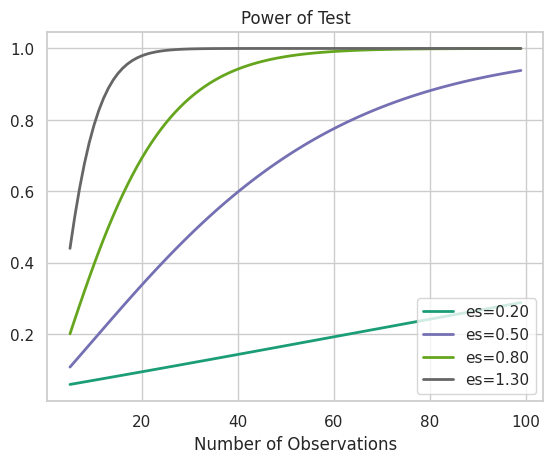

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.power import TTestIndPower

# Power analysis varying parameters
effect_sizes = np.array([0.2, 0.5, 0.8,1.3])
sample_sizes = np.array(range(5, 100))

# Plot power curves
obj = TTestIndPower()
obj.plot_power(dep_var='nobs', nobs=sample_sizes,
			effect_size=effect_sizes)

plt.show()

#Logsitic Regression

In [13]:
# One-hot encode categorical variables
df_log = df[['StripSearch','Perceived_Race','Sex', 'Age_group__at_arrest_']].copy().dropna()
# One-hot encode the categorical variables
x = pd.get_dummies(df_log[['Perceived_Race', 'Sex', 'Age_group__at_arrest_']], drop_first= True)
# Select the response column 
y = df_log[['StripSearch']]
# Display the resulting dataframe
print(x)


       Perceived_Race_East/Southeast Asian  Perceived_Race_Indigenous  \
0                                        0                          0   
1                                        0                          0   
2                                        0                          0   
3                                        0                          0   
4                                        0                          0   
...                                    ...                        ...   
65262                                    0                          1   
65263                                    0                          0   
65264                                    0                          0   
65265                                    0                          0   
65266                                    0                          0   

       Perceived_Race_Latino  Perceived_Race_Middle-Eastern  \
0                          0                              0 

##Assumption check

In [14]:
strip_search_counts = df_log.groupby(['Perceived_Race', 'Sex', 'Age_group__at_arrest_'])['StripSearch'].sum().sort_values(ascending=True)
print("Number of strip searches for each level of categorical variables in descending order:")
print(strip_search_counts)



Number of strip searches for each level of categorical variables in descending order:
Perceived_Race        Sex  Age_group__at_arrest_
South Asian           F    Aged 55 to 64 years        0
Latino                F    Aged 55 to 64 years        0
Unknown or Legacy     F    Aged 65 and older          0
East/Southeast Asian  F    Aged 65 and older          0
Black                 F    Aged 65 and older          0
                                                   ... 
White                 M    Aged 45 to 54 years      437
Black                 M    Aged 18 to 24 years      560
                           Aged 25 to 34 years      804
White                 M    Aged 35 to 44 years      885
                           Aged 25 to 34 years      942
Name: StripSearch, Length: 112, dtype: int64


In [15]:
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65239 entries, 0 to 65266
Data columns (total 14 columns):
 #   Column                                     Non-Null Count  Dtype
---  ------                                     --------------  -----
 0   Perceived_Race_East/Southeast Asian        65239 non-null  uint8
 1   Perceived_Race_Indigenous                  65239 non-null  uint8
 2   Perceived_Race_Latino                      65239 non-null  uint8
 3   Perceived_Race_Middle-Eastern              65239 non-null  uint8
 4   Perceived_Race_South Asian                 65239 non-null  uint8
 5   Perceived_Race_Unknown or Legacy           65239 non-null  uint8
 6   Perceived_Race_White                       65239 non-null  uint8
 7   Sex_M                                      65239 non-null  uint8
 8   Age_group__at_arrest__Aged 18 to 24 years  65239 non-null  uint8
 9   Age_group__at_arrest__Aged 25 to 34 years  65239 non-null  uint8
 10  Age_group__at_arrest__Aged 35 to 44 years  652

In [16]:
# Split these data into training and testing datasets
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state=2178)

In [17]:
x_train

,Perceived_Race_East/Southeast Asian,Perceived_Race_Indigenous,Perceived_Race_Latino,Perceived_Race_Middle-Eastern,Perceived_Race_South Asian,Perceived_Race_Unknown or Legacy,Perceived_Race_White,Sex_M,Age_group__at_arrest__Aged 18 to 24 years,Age_group__at_arrest__Aged 25 to 34 years,Age_group__at_arrest__Aged 35 to 44 years,Age_group__at_arrest__Aged 45 to 54 years,Age_group__at_arrest__Aged 55 to 64 years,Age_group__at_arrest__Aged 65 and older
42569,0,0,0,0,0,0,0,0,0,1,0,0,0,0
43451,0,0,0,0,0,0,1,0,0,1,0,0,0,0
238,0,0,0,0,0,0,0,1,0,1,0,0,0,0
36869,0,0,0,0,0,0,0,1,1,0,0,0,0,0
61990,0,0,0,0,0,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2783,0,0,0,0,0,1,0,1,0,1,0,0,0,0
58365,0,0,0,0,0,0,0,1,1,0,0,0,0,0
52249,0,0,0,0,0,0,0,1,0,0,1,0,0,0
35262,0,0,0,0,1,0,0,1,1,0,0,0,0,0


In [18]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Compute the correlation matrix
correlation_matrix = x_train.corr()
print("Correlation Matrix:")
print(correlation_matrix)


Correlation Matrix:
                                           Perceived_Race_East/Southeast Asian  \
Perceived_Race_East/Southeast Asian                                   1.000000   
Perceived_Race_Indigenous                                            -0.046937   
Perceived_Race_Latino                                                -0.044516   
Perceived_Race_Middle-Eastern                                        -0.061237   
Perceived_Race_South Asian                                           -0.065212   
Perceived_Race_Unknown or Legacy                                     -0.077441   
Perceived_Race_White                                                 -0.230076   
Sex_M                                                                 0.016896   
Age_group__at_arrest__Aged 18 to 24 years                             0.027614   
Age_group__at_arrest__Aged 25 to 34 years                            -0.026562   
Age_group__at_arrest__Aged 35 to 44 years                            -0.000588

In [19]:
# Compute VIF for each independent variable
vif = pd.DataFrame()
vif["features"] = x_train.columns
vif["vif"] = [variance_inflation_factor(x_train.values, i) for i in range(x_train.shape[1])]
print("Variance Inflation Factors (VIF):")
print(vif)


Variance Inflation Factors (VIF):
                                     features       vif
0         Perceived_Race_East/Southeast Asian  0.051230
1                   Perceived_Race_Indigenous  0.020615
2                       Perceived_Race_Latino  0.102379
3               Perceived_Race_Middle-Eastern  0.021969
4                  Perceived_Race_South Asian  0.050285
5            Perceived_Race_Unknown or Legacy  0.065985
6                        Perceived_Race_White  0.026194
7                                       Sex_M  0.014911
8   Age_group__at_arrest__Aged 18 to 24 years  0.021478
9   Age_group__at_arrest__Aged 25 to 34 years  0.023437
10  Age_group__at_arrest__Aged 35 to 44 years  0.023014
11  Age_group__at_arrest__Aged 45 to 54 years  0.032142
12  Age_group__at_arrest__Aged 55 to 64 years  0.024347
13    Age_group__at_arrest__Aged 65 and older  0.042157


In [20]:
# Compute tolerance values
tolerance = 1 / vif["vif"]
print("Tolerance Values:")
print(tolerance)


Tolerance Values:
0     19.519628
1     48.509528
2      9.767652
3     45.518890
4     19.886614
5     15.154928
6     38.176729
7     67.066751
8     46.559746
9     42.668397
10    43.451778
11    31.112369
12    41.072902
13    23.720936
Name: vif, dtype: float64


##Result

In [21]:
# Create the formula string
x = x_train.columns
x = x.str.replace(' ', '_')
x = x.str.replace('/', '_')
x = x.str.replace('-', '_')
x = x.str.replace('(', '_')
x = x.str.replace(')', '_')
all_columns = ' + '.join(x)
formula = "StripSearch ~ " + all_columns
print("Formula: ", formula, "\n")

# Put the training predictors and responses into one DataFrame to be input into the model
trainingdata = pd.concat([x_train, y_train], axis=1)
trainingdata.columns = trainingdata.columns.str.replace(' ', '_')
trainingdata.columns = trainingdata.columns.str.replace('/', '_')
trainingdata.columns = trainingdata.columns.str.replace('-', '_')
trainingdata.columns = trainingdata.columns.str.replace('(', '_')
trainingdata.columns = trainingdata.columns.str.replace(')', '_')

# Build the model
log_reg_1 = smf.logit(formula, data=trainingdata).fit()
print(log_reg_1.summary())


<ipython-input-21-aff45d7b3d6b>:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  x = x.str.replace('(', '_')
<ipython-input-21-aff45d7b3d6b>:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  x = x.str.replace(')', '_')
<ipython-input-21-aff45d7b3d6b>:17: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  trainingdata.columns = trainingdata.columns.str.replace('(', '_')
<ipython-input-21-aff45d7b3d6b>:18: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character 

Formula:  StripSearch ~ Perceived_Race_East_Southeast_Asian + Perceived_Race_Indigenous + Perceived_Race_Latino + Perceived_Race_Middle_Eastern + Perceived_Race_South_Asian + Perceived_Race_Unknown_or_Legacy + Perceived_Race_White + Sex_M + Age_group__at_arrest__Aged_18_to_24_years + Age_group__at_arrest__Aged_25_to_34_years + Age_group__at_arrest__Aged_35_to_44_years + Age_group__at_arrest__Aged_45_to_54_years + Age_group__at_arrest__Aged_55_to_64_years + Age_group__at_arrest__Aged_65_and_older 

Optimization terminated successfully.
         Current function value: 0.357776
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:            StripSearch   No. Observations:                52191
Model:                          Logit   Df Residuals:                    52176
Method:                           MLE   Df Model:                           14
Date:                Sun, 16 Apr 2023   Pseudo R-squ.:                 0.01859


In [22]:
# Calculate the odds ratios
odds_ratios = np.exp(log_reg_1.params)

# Print the odds ratios
print("Odds Ratios:")
print(odds_ratios)


Odds Ratios:
Intercept                                    0.091314
Perceived_Race_East_Southeast_Asian          0.551365
Perceived_Race_Indigenous                    1.254209
Perceived_Race_Latino                        0.550740
Perceived_Race_Middle_Eastern                0.454573
Perceived_Race_South_Asian                   0.490349
Perceived_Race_Unknown_or_Legacy             0.749747
Perceived_Race_White                         0.987875
Sex_M                                        1.373369
Age_group__at_arrest__Aged_18_to_24_years    1.539679
Age_group__at_arrest__Aged_25_to_34_years    1.452866
Age_group__at_arrest__Aged_35_to_44_years    1.404382
Age_group__at_arrest__Aged_45_to_54_years    1.059219
Age_group__at_arrest__Aged_55_to_64_years    0.752089
Age_group__at_arrest__Aged_65_and_older      0.222826
dtype: float64


In [23]:
# Calculate the odds ratios and confidence intervals
params = log_reg_1.params
conf = log_reg_1.conf_int()
conf['OR'] = params
conf.columns = ["Lower CI", "Upper CI", "OR"]
np.exp(conf)


,Lower CI,Upper CI,OR
Intercept,0.078477,0.106251,0.091314
Perceived_Race_East_Southeast_Asian,0.482418,0.630165,0.551365
Perceived_Race_Indigenous,1.085223,1.449510,1.254209
Perceived_Race_Latino,0.452202,0.670751,0.550740
Perceived_Race_Middle_Eastern,0.387377,0.533425,0.454573
Perceived_Race_South_Asian,0.422655,0.568884,0.490349
Perceived_Race_Unknown_or_Legacy,0.670107,0.838852,0.749747
Perceived_Race_White,0.926632,1.053166,0.987875
Sex_M,1.277494,1.476439,1.373369
Age_group__at_arrest__Aged_18_to_24_years,1.324455,1.789878,1.539679


Assess model

In [24]:
from sklearn.metrics import confusion_matrix, accuracy_score
# Preprocess the x_test data
x_test_processed = x_test.copy()
x_test_processed.columns = x_test_processed.columns.str.replace(' ', '_')
x_test_processed.columns = x_test_processed.columns.str.replace('/', '_')
x_test_processed.columns = x_test_processed.columns.str.replace('-', '_')
x_test_processed.columns = x_test_processed.columns.str.replace('(', '_')
x_test_processed.columns = x_test_processed.columns.str.replace(')', '_')
# Predict responses
pred_1 = log_reg_1.predict(x_test_processed)

# Round the predictions
prediction_1 = list(map(round, pred_1))


<ipython-input-24-7b23aaf0f058>:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  x_test_processed.columns = x_test_processed.columns.str.replace('(', '_')
<ipython-input-24-7b23aaf0f058>:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  x_test_processed.columns = x_test_processed.columns.str.replace(')', '_')


In [25]:
# Calculate the accuracy score
acc = accuracy_score(y_test, prediction_1)
print("Accuracy:", acc)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, prediction_1)
print("Confusion Matrix:")
print(cm)

Accuracy: 0.8774524831391785
Confusion Matrix:
[[11449     0]
 [ 1599     0]]


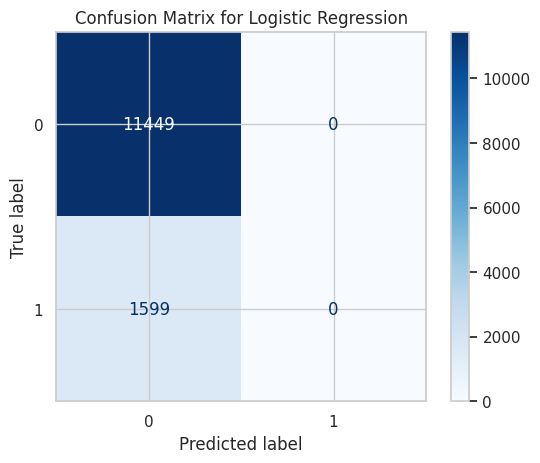

In [26]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Logistic Regression")
plt.show()

Contingency Table


In [27]:
# Create a contingency table using the 'crosstab' function in pandas
contingency_table = pd.crosstab(df['Perceived_Race'], df['StripSearch'])

# Add a row for the total count of each column
contingency_table.loc['Total'] = contingency_table.sum()

# Add a column for the total count of each row
contingency_table['Total'] = contingency_table.sum(axis=1)

# Display the contingency table
print(contingency_table)


StripSearch               0     1  Total
Perceived_Race                          
Black                 15092  2434  17526
East/Southeast Asian   4074   341   4415
Indigenous             1628   306   1934
Latino                 1635   132   1767
Middle-Eastern         3009   228   3237
South Asian            3356   257   3613
Unknown or Legacy      4517   536   5053
White                 24152  3566  27718
Total                 57463  7800  65263


EDA

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import statsmodels.api as sm
from statsmodels.formula.api import ols
import numpy as np
from scipy import stats

# Create pandas dataframe 
df1 = pd.read_csv('Arrests_and_Strip_Searches_(RBDC-ARR-TBL-001).csv')

# Filter out "U" in the "Sex" column
df2 = df1[df1['Sex'] != 'U']

# Group 17 years and under 
df2['Age_group__at_arrest_'] = df2['Age_group__at_arrest_'].replace('Aged 17 years and younger', 'Aged 17 years and under')
df2['Youth_at_arrest__under_18_years'] = df2['Youth_at_arrest__under_18_years'].replace('Youth (aged 17 and younger)', 'Youth (aged 17 years and under)')

# Save the updated dataset
df2.to_csv('updated_arrests.csv', index=False)

# Group the 65 years and older
df2['Age_group__at_arrest_'] = df2['Age_group__at_arrest_'].replace('Aged 65 years and older', 'Aged 65 and older')

# Save the updated dataset
df2.to_csv('updated_arrests.csv', index=False)

# Set the new dataframe
df = pd.read_csv('updated_arrests.csv')

subset = df[['PersonID', 'StripSearch','Sex', 'Perceived_Race','Age_group__at_arrest_','Youth_at_arrest__under_18_years','ArrestLocDiv']].dropna()
strip_search_sum = subset.groupby(['PersonID','Sex', 'Perceived_Race', 'Age_group__at_arrest_','Youth_at_arrest__under_18_years'])['StripSearch'].agg('sum').reset_index(name='strip_search_sum').dropna()
strip_search_sum = strip_search_sum.sort_values(by='strip_search_sum', ascending=False)

print(strip_search_sum)

<ipython-input-29-2b239a4af108>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Age_group__at_arrest_'] = df2['Age_group__at_arrest_'].replace('Aged 17 years and younger', 'Aged 17 years and under')
<ipython-input-29-2b239a4af108>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Youth_at_arrest__under_18_years'] = df2['Youth_at_arrest__under_18_years'].replace('Youth (aged 17 and younger)', 'Youth (aged 17 years and under)')
<ipython-input-29-2b239a4af108>:24: SettingWithCopyWarning: 
A value i

       PersonID Sex     Perceived_Race Age_group__at_arrest_  \
4295     303892   M         Indigenous   Aged 35 to 44 years   
40790    337011   M              White   Aged 25 to 34 years   
25913    323471   M              Black   Aged 25 to 34 years   
27039    324487   M              Black   Aged 45 to 54 years   
17318    315676   M              White   Aged 18 to 24 years   
...         ...  ..                ...                   ...   
14675    313272   F              White   Aged 45 to 54 years   
14676    313273   M  Unknown or Legacy   Aged 45 to 54 years   
14677    313274   M              Black   Aged 25 to 34 years   
14678    313275   M         Indigenous   Aged 45 to 54 years   
41153    337346   M              White   Aged 18 to 24 years   

      Youth_at_arrest__under_18_years  strip_search_sum  
4295                      Not a youth                13  
40790                     Not a youth                12  
25913                     Not a youth                12  

<ipython-input-30-388d754ed62c>:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x= "Perceived_Race", y= "strip_search_sum", hue= "Sex", data = strip_search_sum, palette =['#00876c','#00c2ba'],ci=None)


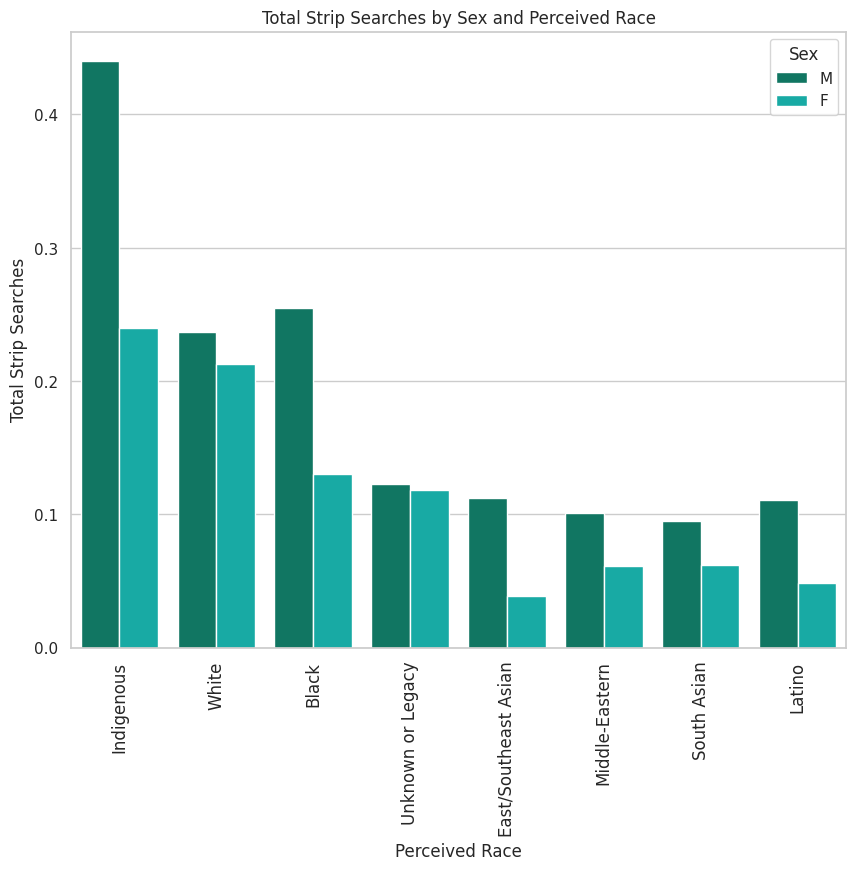

In [30]:
# Create a larger figure
plt.figure(figsize=(10, 8))

# Create the bar plot 
ax = sns.barplot(x= "Perceived_Race", y= "strip_search_sum", hue= "Sex", data = strip_search_sum, palette =['#00876c','#00c2ba'],ci=None)
plt.xticks(rotation=90, fontsize=12)

# Set the title of the plot
ax.set_title("Total Strip Searches by Sex and Perceived Race")

# Add labels to the axes
ax.set_xlabel("Perceived Race")
ax.set_ylabel("Total Strip Searches")

# Show the plot
plt.show()

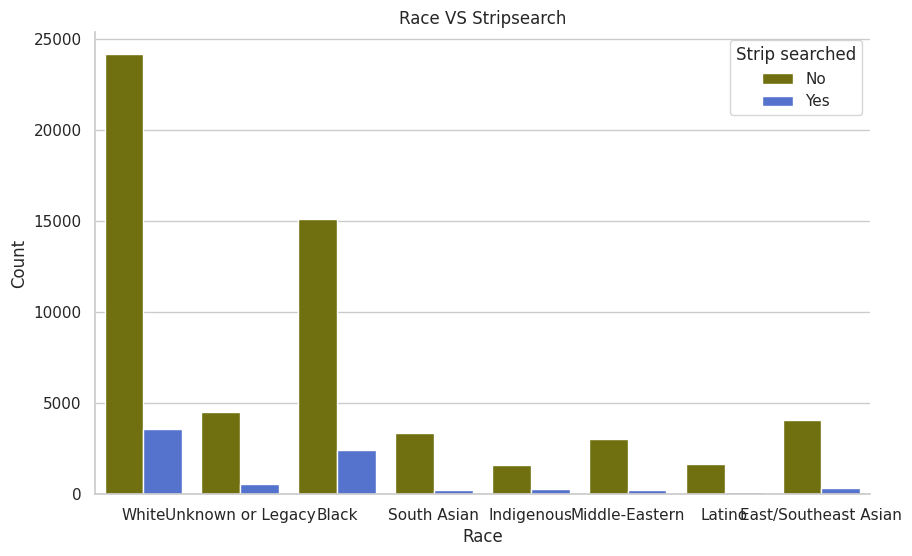

In [31]:
# Visualizing "Race" vs "stripsearch"
def Race_vs_Stripsearch():
    plt.figure(figsize=(10, 6))
    sns.countplot(x= "Perceived_Race", hue= "StripSearch", data= df, palette= ['olive','royalblue'])
    plt.xlabel("Race")
    plt.ylabel("Count")
    plt.title("Race VS Stripsearch")
    plt.legend(title="Strip searched", labels=["No", "Yes"])
    sns.despine()
    plt.show()
    
# Display the chart
Race_vs_Stripsearch()

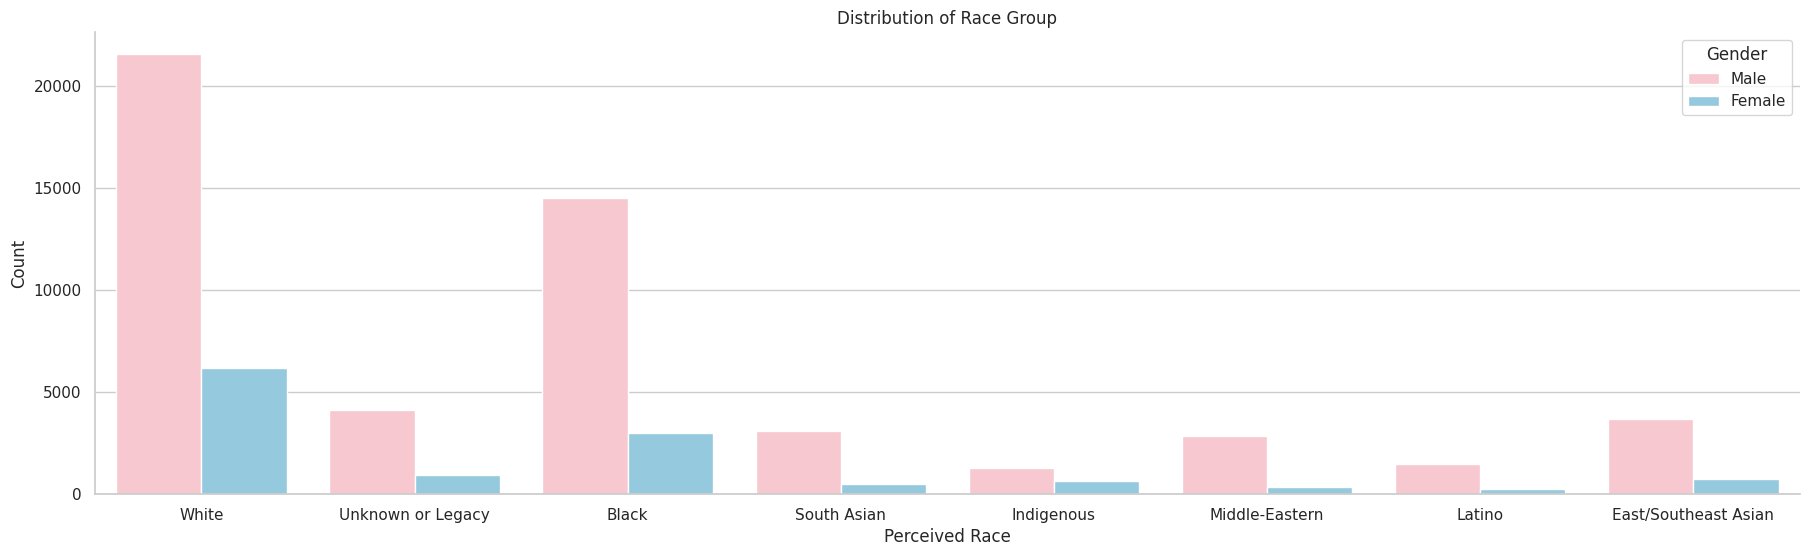

In [32]:
# Visualizing the variable "Race" vs "counts"

def Race_vs_counts():
    plt.figure(figsize=(22, 6))
    sns.countplot(x="Perceived_Race", hue="Sex", data=df, palette=['pink','skyblue'])
    plt.xlabel("Perceived Race")
    plt.ylabel("Count")
    plt.title("Distribution of Race Group")
    plt.legend(title="Gender", labels=["Male", "Female"])
    sns.despine()
    plt.show()

Race_vs_counts()

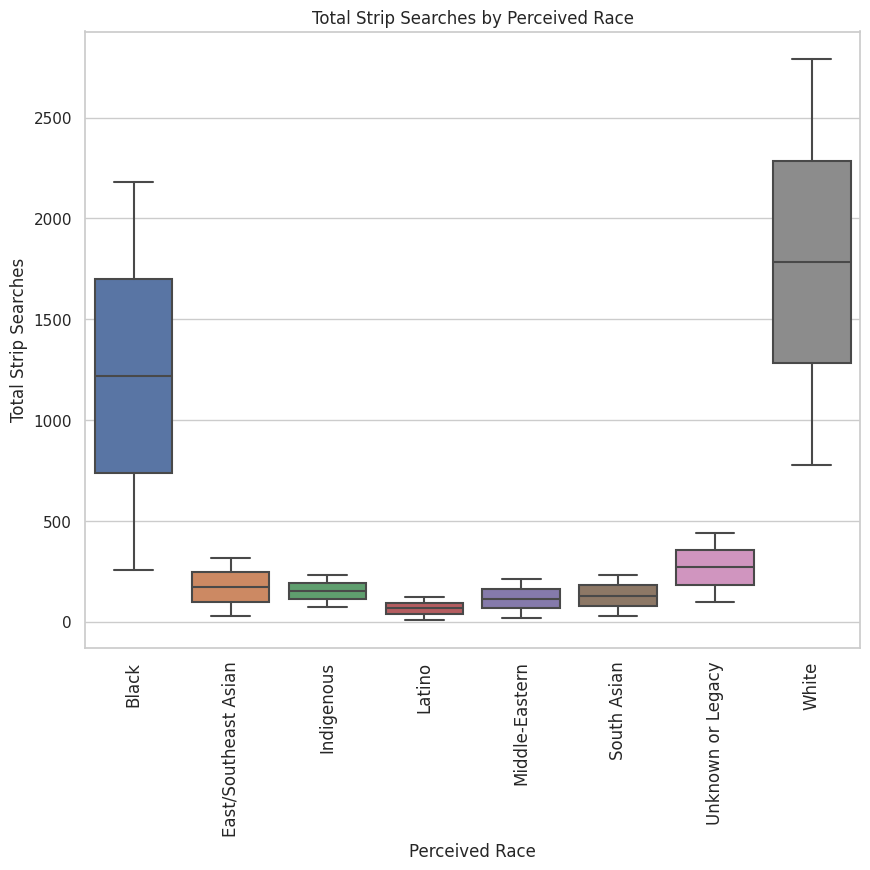

In [33]:
import matplotlib.pyplot as plt

# Group the data by Perceived_Race and StripSearch columns and calculate the sum

race_sum = subset.groupby(['Sex', 'Perceived_Race'])['StripSearch'].agg('sum').reset_index(name='race_sum').dropna()


sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(10, 8))

# Create the bar plot using seaborn
ax = sns.boxplot(data = race_sum, x = "Perceived_Race", y="race_sum")
plt.xticks(rotation=90, fontsize=12)

# Set the title of the plot
ax.set_title("Total Strip Searches by Perceived Race")

# Add labels to the axes
ax.set_xlabel("Perceived Race")
ax.set_ylabel("Total Strip Searches")

# Show the plot
plt.show()

In [34]:
# select the subset of columns we need and drop missing values
subset = df[['Perceived_Race', 'StripSearch']].dropna()

# create a cross-tabulation of the variables
table = pd.crosstab(subset['Perceived_Race'], subset['StripSearch'], normalize='index') * 100

# format the percentages
table = table.applymap(lambda x: '{:.2f}%'.format(x))
# rename the columns to "No" and "Yes"
table.columns = ['No', 'Yes']
# print the table
print(table)

                          No     Yes
Perceived_Race                      
Black                 86.11%  13.89%
East/Southeast Asian  92.28%   7.72%
Indigenous            84.18%  15.82%
Latino                92.53%   7.47%
Middle-Eastern        92.96%   7.04%
South Asian           92.89%   7.11%
Unknown or Legacy     89.39%  10.61%
White                 87.13%  12.87%


<ipython-input-35-388d754ed62c>:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x= "Perceived_Race", y= "strip_search_sum", hue= "Sex", data = strip_search_sum, palette =['#00876c','#00c2ba'],ci=None)


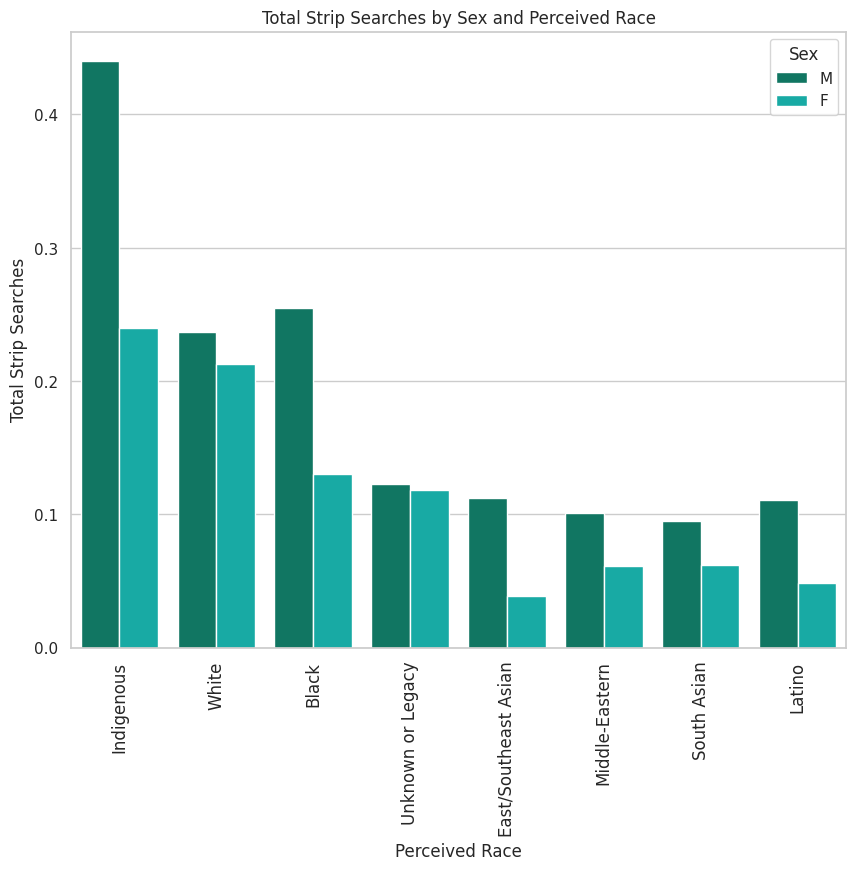

In [35]:
# Create a larger figure
plt.figure(figsize=(10, 8))

# Create the bar plot 
ax = sns.barplot(x= "Perceived_Race", y= "strip_search_sum", hue= "Sex", data = strip_search_sum, palette =['#00876c','#00c2ba'],ci=None)
plt.xticks(rotation=90, fontsize=12)

# Set the title of the plot
ax.set_title("Total Strip Searches by Sex and Perceived Race")

# Add labels to the axes
ax.set_xlabel("Perceived Race")
ax.set_ylabel("Total Strip Searches")

# Show the plot
plt.show()

<ipython-input-36-f1726a52e27a>:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x= "Age_group__at_arrest_", y= "strip_search_sum", hue= "Sex", data = strip_search_sum, palette =['#00876c','#00c2ba'],ci=None)


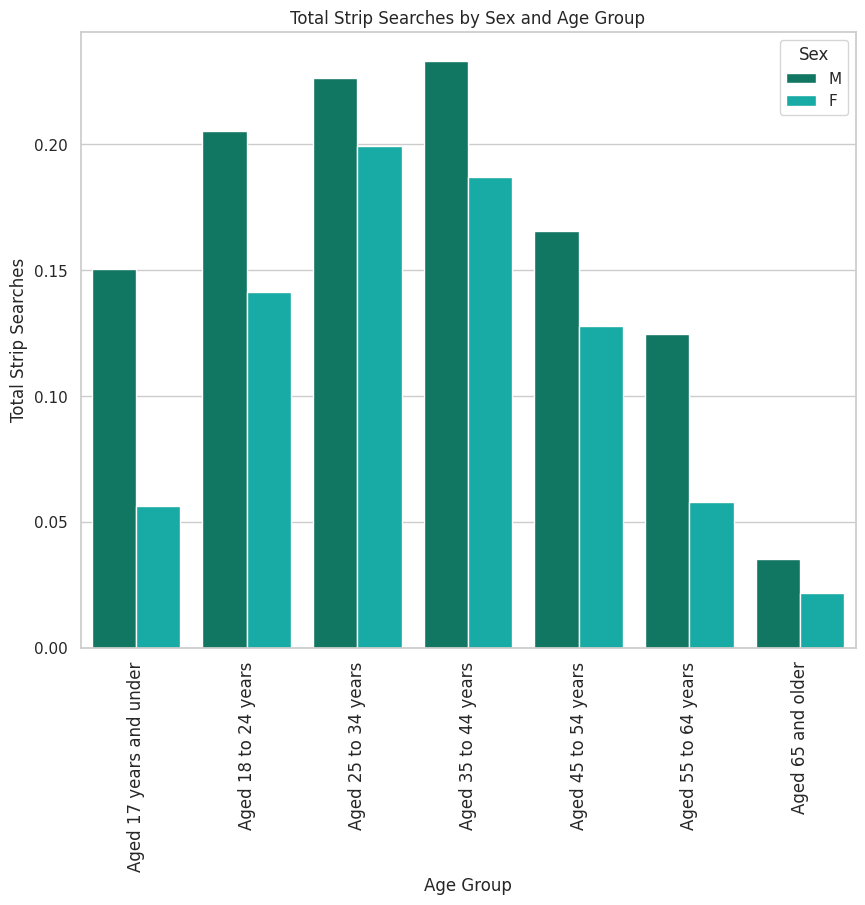

In [36]:
strip_search_sum = strip_search_sum.sort_values("Age_group__at_arrest_")
# Create a larger figure
plt.figure(figsize=(10, 8))

# Create the bar plot 
ax = sns.barplot(x= "Age_group__at_arrest_", y= "strip_search_sum", hue= "Sex", data = strip_search_sum, palette =['#00876c','#00c2ba'],ci=None)
plt.xticks(rotation=90, fontsize=12)

# Set the title of the plot
ax.set_title("Total Strip Searches by Sex and Age Group")

# Add labels to the axes
ax.set_xlabel("Age Group")
ax.set_ylabel("Total Strip Searches")

# Show the plot
plt.show()

<ipython-input-37-0759544e789a>:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x= "Youth_at_arrest__under_18_years", y= "strip_search_sum", hue= "Sex", data = strip_search_sum, palette =['#00876c','#00c2ba'], ci=None)


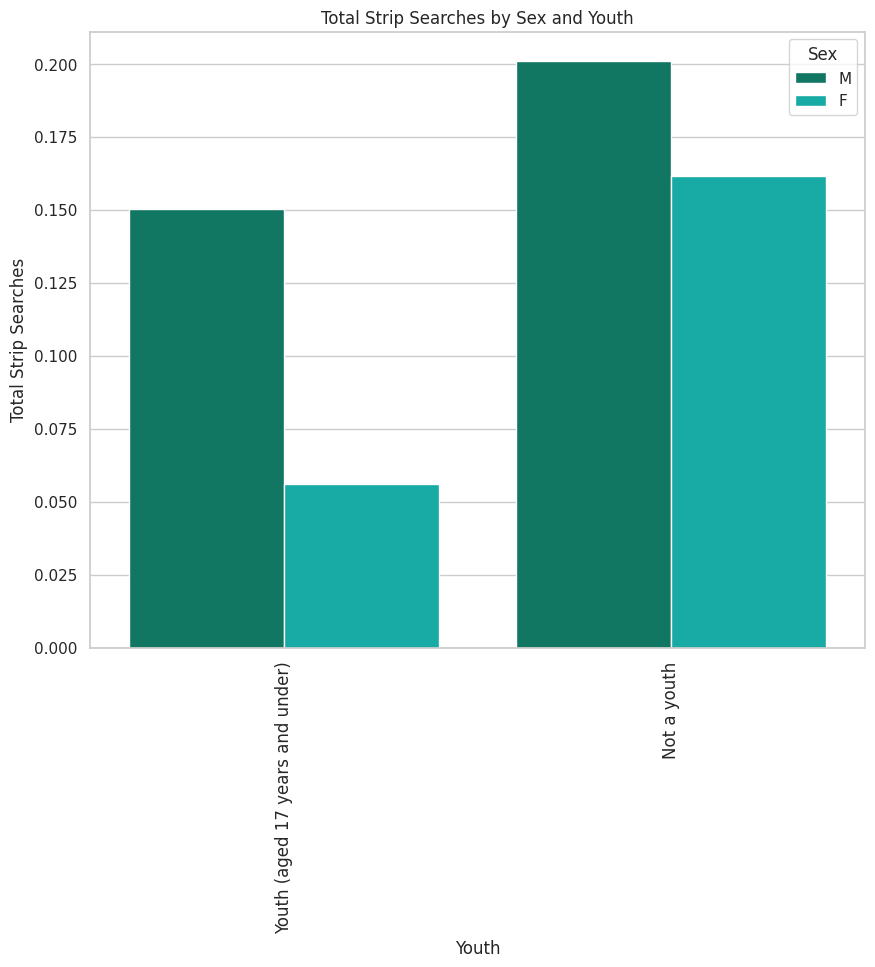

In [37]:
# Create a larger figure
plt.figure(figsize=(10, 8))

# Create the bar plot 
ax = sns.barplot(x= "Youth_at_arrest__under_18_years", y= "strip_search_sum", hue= "Sex", data = strip_search_sum, palette =['#00876c','#00c2ba'], ci=None)
plt.xticks(rotation=90, fontsize=12)

# Set the title of the plot
ax.set_title("Total Strip Searches by Sex and Youth")

# Add labels to the axes
ax.set_xlabel("Youth")
ax.set_ylabel("Total Strip Searches")

# Show the plot
plt.show()

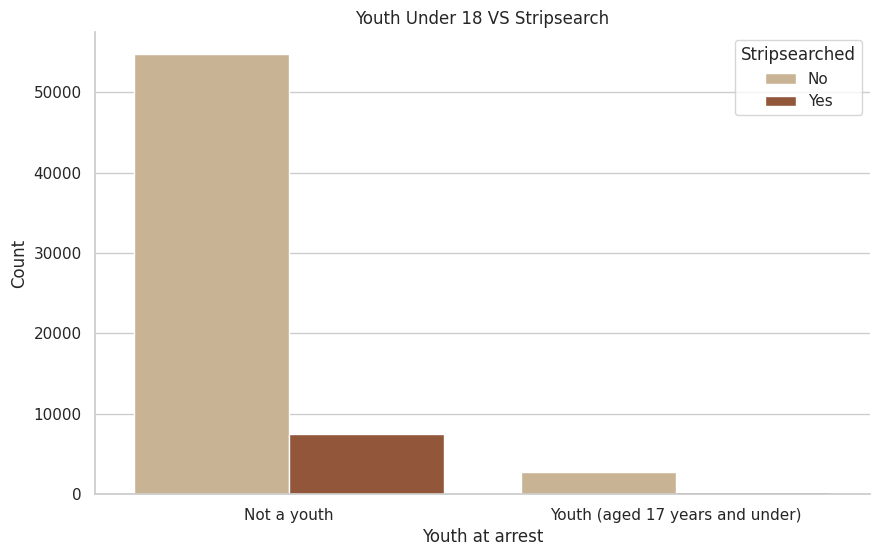

In [38]:
# Combine the two aged 17 years and under into one category  
df['Youth_at_arrest__under_18_years'] = df['Youth_at_arrest__under_18_years'].replace('Youth (aged 17 and younger)', 'Youth (aged 17 years and under)')

# Visualiza the chart
def Youth_at_arrest__under_18_years_vs_Stripsearch():
    plt.figure(figsize=(10, 6))
    sns.countplot(x="Youth_at_arrest__under_18_years", hue="StripSearch", data=df, palette=['tan','sienna'])
    plt.ylabel("Count")
    plt.xlabel("Youth at arrest")
    plt.title("Youth Under 18 VS Stripsearch")
    plt.legend(title="Stripsearched", labels=["No", "Yes"])
    sns.despine()
    plt.show()

Youth_at_arrest__under_18_years_vs_Stripsearch()

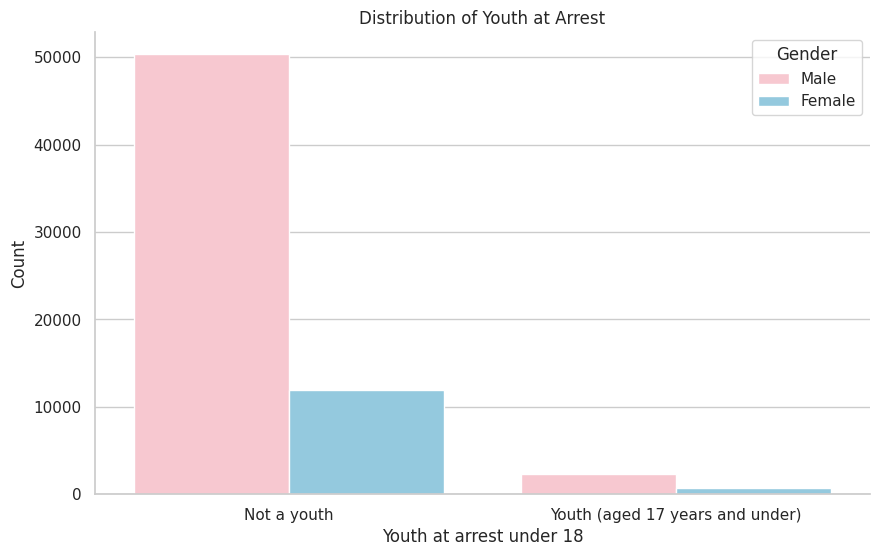

In [39]:
# Visualizing the variable "Age" vs "counts"

def Age_vs_counts():
    plt.figure(figsize=(10, 6))
    sns.countplot(x="Youth_at_arrest__under_18_years", hue="Sex", data=df, palette=['pink','skyblue'])
    plt.xlabel("Youth at arrest under 18")
    plt.ylabel("Count")
    plt.title("Distribution of Youth at Arrest")
    plt.legend(title="Gender", labels=["Male", "Female"])
    sns.despine()
    plt.show()

Age_vs_counts()

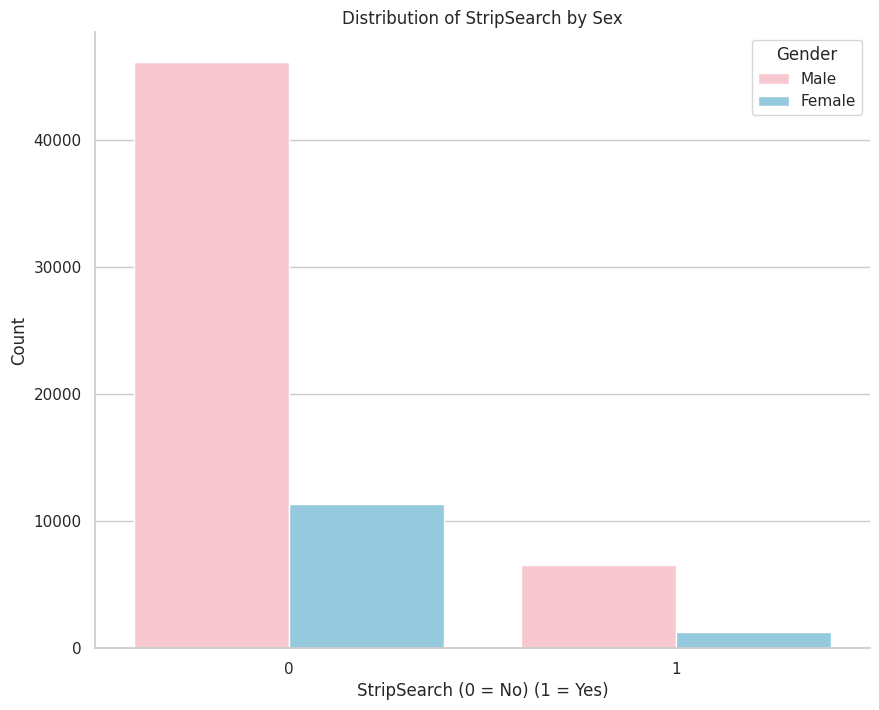

In [40]:
# Visualizing the variable "Stripsearch" vs "counts"
plt.figure(figsize=(10, 8))
sns.countplot(x = "StripSearch", hue = 'Sex', data=df, palette=['pink','skyblue'])
plt.xlabel("StripSearch (0 = No) (1 = Yes)")
plt.ylabel("Count")
plt.title("Distribution of StripSearch by Sex")
plt.legend(title="Gender", labels=["Male", "Female"])
sns.despine()
plt.show()

In [41]:
from tabulate import tabulate

# Group by "Sex" and "strip search"
grouped = df.groupby(['Sex', 'StripSearch'])

# Descriptive statistics
desc_stats = grouped.size().reset_index(name='count')
desc_stats['percentage'] = desc_stats['count'] / desc_stats['count'].sum() * 100
desc_stats['percentage'] = desc_stats['percentage'].apply(lambda x: '{:.2f}%'.format(x))  # format percentage column

# Print the table
title = "Strip Searches by Sex"
print(tabulate(desc_stats, headers='keys', tablefmt='simple', showindex=False, floatfmt='.2f'))

Sex      StripSearch    count  percentage
-----  -------------  -------  ------------
F                  0    11334  17.37%
F                  1     1283  1.97%
M                  0    46132  70.68%
M                  1     6518  9.99%


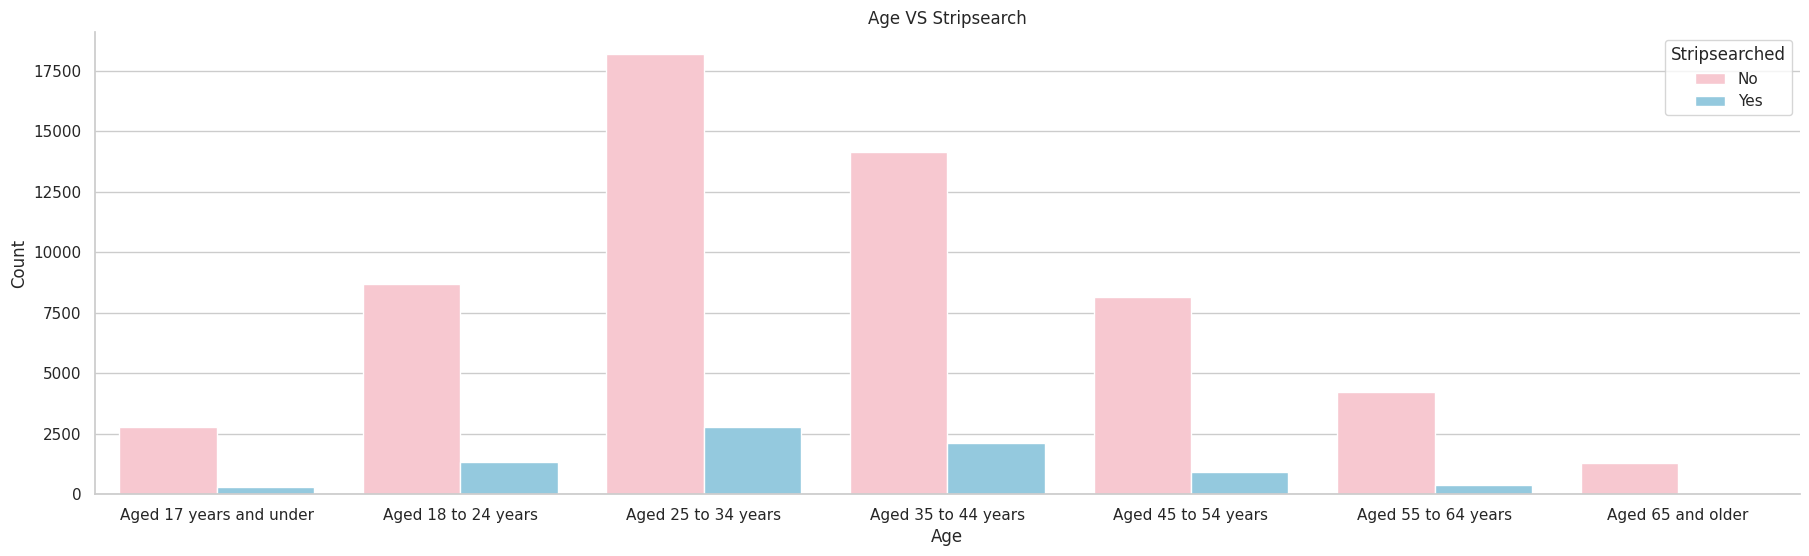

In [42]:
# Visualizing the variable "Age" vs "stripsearch"
df = df.sort_values("Age_group__at_arrest_")
plt.figure(figsize=(22, 6))
sns.countplot(x="Age_group__at_arrest_", hue="StripSearch", data=df, palette=['pink','skyblue'])
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Age VS Stripsearch")
plt.legend(title="Stripsearched", labels=["No", "Yes"])
sns.despine()
plt.show()

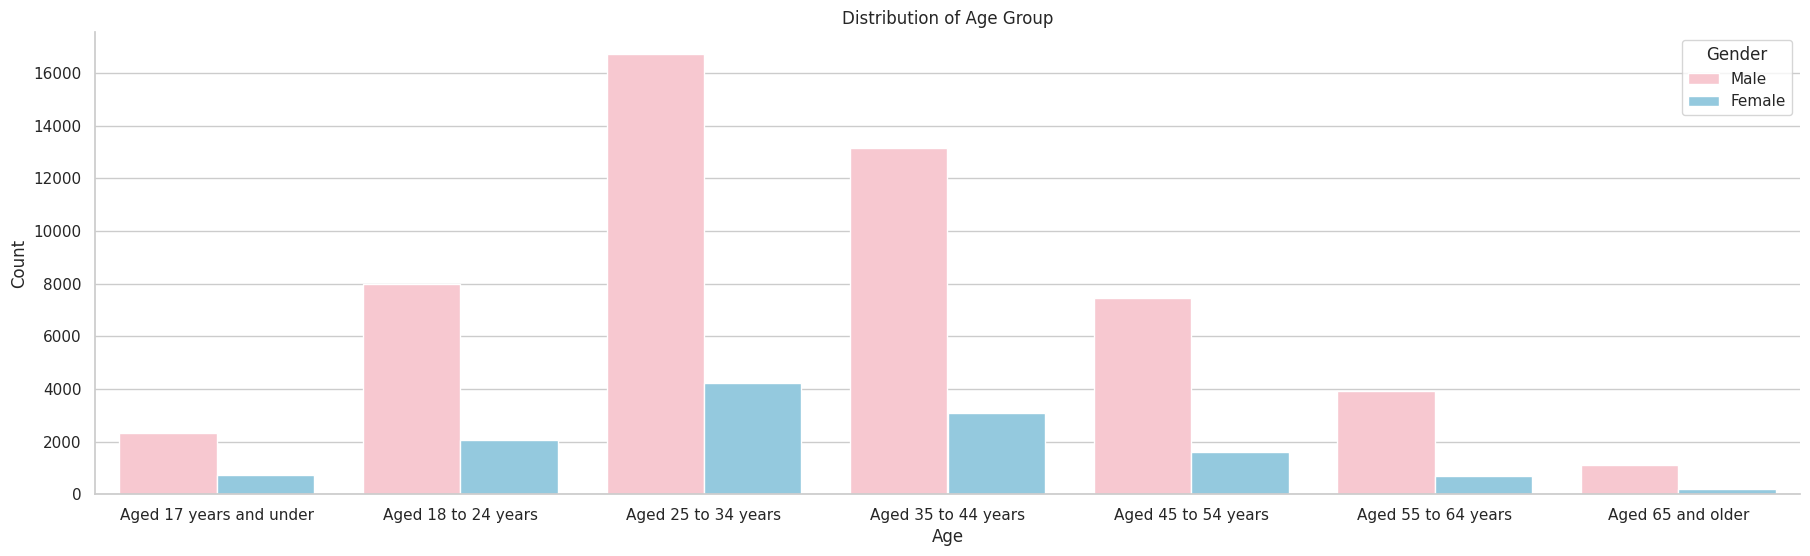

In [43]:
# Visualizing the variable "Age" vs "counts"

def Age_vs_counts():
    plt.figure(figsize=(22, 6))
    sns.countplot(x="Age_group__at_arrest_", hue="Sex", data=df, palette=['pink','skyblue'])
    plt.xlabel("Age")
    plt.ylabel("Count")
    plt.title("Distribution of Age Group")
    plt.legend(title="Gender", labels=["Male", "Female"])
    sns.despine()
    plt.show()
    
Age_vs_counts()

In [44]:
# Pulled out people who has been strip searched 
searched_df = df[df['StripSearch'] == 1]
searched_df
# Find the frequency of each age group that has been strip searched 
age_freq = searched_df.groupby('Age_group__at_arrest_')['Age_group__at_arrest_'].count()
age_freq

Age_group__at_arrest_
Aged 17 years and under     280
Aged 18 to 24 years        1349
Aged 25 to 34 years        2771
Aged 35 to 44 years        2098
Aged 45 to 54 years         905
Aged 55 to 64 years         362
Aged 65 and older            36
Name: Age_group__at_arrest_, dtype: int64

T-Test

In [45]:
clean_sub = df[['PersonID', 'StripSearch','Sex', 'Perceived_Race','Age_group__at_arrest_','Youth_at_arrest__under_18_years']].dropna()
# group by person ID and sum up the number of times been strip searched
Sum_id = clean_sub.groupby(['PersonID','Sex','Perceived_Race'])['StripSearch'].sum().reset_index(name='StripSearch')
#two-sided t-test
male_search = Sum_id[Sum_id['Sex'] == 'M']['StripSearch'].values
female_search = Sum_id[Sum_id['Sex'] == 'F']['StripSearch'].values

# Conduct t-test
t_stat, p_value = stats.ttest_ind(male_search, female_search)

# Print results
print("t-statistic = ", t_stat)
print("p-value = ", p_value)

t-statistic =  5.87888675750744
p-value =  4.162739318145988e-09


In [46]:
# One-sided, greater than test
t_stat, p_value = stats.ttest_ind(male_search, female_search, alternative='greater')

print("t-statistic = ", t_stat)
print("p-value = ", p_value)

t-statistic =  5.87888675750744
p-value =  2.081369659072994e-09


In [47]:
# One-sided, less than test
t_stat, p_value = stats.ttest_ind(male_search, female_search, alternative='less')
print("t-statistic = ", t_stat)
print("p-value = ", p_value)

t-statistic =  5.87888675750744
p-value =  0.9999999979186304


In [48]:
# Calculate means and standard errors
mean_male = male_search.mean()
mean_female = female_search.mean()
se_male = male_search.std() / np.sqrt(len(male_search))
se_female = female_search.std() / np.sqrt(len(female_search))

# Calculate standard error of the difference
se_diff = np.sqrt(se_male**2 + se_female**2)

# Calculate degrees of freedom
df = len(male_search) + len(female_search) - 2

# Set the confidence level
alpha = 0.05

# Calculate the t-value for the desired confidence level and degrees of freedom
t_crit = abs(stats.t.ppf(alpha/2, df))

# Calculate the margin of error
moe = t_crit * se_diff

# Calculate the confidence interval
ci_lower = (mean_male - mean_female) - moe
ci_upper = (mean_male - mean_female) + moe

print(f"95% Confidence Interval: ({ci_lower:.2f}, {ci_upper:.2f})")

95% Confidence Interval: (0.03, 0.06)


In [49]:
white_search = Sum_id[Sum_id['Perceived_Race'] == 'Black']['StripSearch'].values
black_search = Sum_id[Sum_id['Perceived_Race'] == 'White']['StripSearch'].values

# Conduct t-test
t_stat, p_value = stats.ttest_ind(white_search, black_search)

# Print results
print("t-statistic = ", t_stat)
print("p-value = ", p_value)

t-statistic =  0.1404107406542711
p-value =  0.8883365891341579


In [50]:
# One-sided, greater than test
t_stat, p_value = stats.ttest_ind(white_search, black_search, alternative='greater')

print("t-statistic = ", t_stat)
print("p-value = ", p_value)

t-statistic =  0.1404107406542711
p-value =  0.44416829456707896


In [51]:
# One-sided, less than test
t_stat, p_value = stats.ttest_ind(white_search, black_search, alternative='less')
print("t-statistic = ", t_stat)
print("p-value = ", p_value)

t-statistic =  0.1404107406542711
p-value =  0.555831705432921


In [52]:
# Calculate means and standard errors
mean_wh = white_search.mean()
mean_bla = black_search.mean()
se_wh = white_search.std() / np.sqrt(len(white_search))
se_bla = black_search.std() / np.sqrt(len(black_search))

# Calculate standard error of the difference
se_diff = np.sqrt(se_wh**2 + se_bla**2)

# Calculate degrees of freedom
df = len(white_search) + len(black_search) - 2

# Set the confidence level
alpha = 0.05

# Calculate the t-value for the desired confidence level and degrees of freedom
t_crit = abs(stats.t.ppf(alpha/2, df))

# Calculate the margin of error
moe = t_crit * se_diff

# Calculate the confidence interval
ci_lower = (mean_wh - mean_bla) - moe
ci_upper = (mean_wh - mean_bla) + moe

print(f"95% Confidence Interval: ({ci_lower:.2f}, {ci_upper:.2f})")

95% Confidence Interval: (-0.02, 0.02)


In [53]:
Sum_id_youth = clean_sub.groupby(['PersonID','Youth_at_arrest__under_18_years'])['StripSearch'].sum().reset_index(name='StripSearch')
#two-sided t-test
youth_search = Sum_id_youth[Sum_id_youth['Youth_at_arrest__under_18_years'] != 'Not a youth']['StripSearch'].values
noty_search = Sum_id_youth[Sum_id_youth['Youth_at_arrest__under_18_years'] == 'Not a youth']['StripSearch'].values

# Conduct t-test
t_stat, p_value = stats.ttest_ind(youth_search, noty_search)

# Print results
print("t-statistic = ", t_stat)
print("p-value = ", p_value)

t-statistic =  -5.034960394701557
p-value =  4.801627170247833e-07


In [54]:
# One-sided, greater than test
t_stat, p_value = stats.ttest_ind(youth_search, noty_search, alternative='greater')

print("t-statistic = ", t_stat)
print("p-value = ", p_value)

t-statistic =  -5.034960394701557
p-value =  0.9999997599186414


In [55]:
# One-sided, less than test
t_stat, p_value = stats.ttest_ind(youth_search, noty_search, alternative='less')
print("t-statistic = ", t_stat)
print("p-value = ", p_value)

t-statistic =  -5.034960394701557
p-value =  2.4008135851239164e-07


In [56]:
# Calculate means and standard errors
mean_youth = youth_search.mean()
mean_noty = noty_search.mean()
se_youth = youth_search.std() / np.sqrt(len(youth_search))
se_noty = noty_search.std() / np.sqrt(len(noty_search))

# Calculate standard error of the difference
se_diff = np.sqrt(se_youth**2 + se_noty**2)

# Calculate degrees of freedom
df = len(youth_search) + len(noty_search) - 2

# Set the confidence level
alpha = 0.05

# Calculate the t-value for the desired confidence level and degrees of freedom
t_crit = abs(stats.t.ppf(alpha/2, df))

# Calculate the margin of error
moe = t_crit * se_diff

# Calculate the confidence interval
ci_lower = (mean_youth - mean_noty) - moe
ci_upper = (mean_youth - mean_noty) + moe

print(f"95% Confidence Interval: ({ci_lower:.2f}, {ci_upper:.2f})")

95% Confidence Interval: (-0.10, -0.06)


In [57]:
Sum_id_age = clean_sub.groupby(['PersonID','Age_group__at_arrest_'])['StripSearch'].sum().reset_index(name='StripSearch')
# Two-sided t-test
yoage_search = Sum_id_age[Sum_id_age['Age_group__at_arrest_'] == 'Aged 18 to 24 years']['StripSearch'].values
midage_search = Sum_id_age[Sum_id_age['Age_group__at_arrest_'] == 'Aged 35 to 44 years']['StripSearch'].values

# Conduct t-test
t_stat, p_value = stats.ttest_ind(yoage_search, midage_search)

# Print results
print("t-statistic = ", t_stat)
print("p-value = ", p_value)

t-statistic =  -3.2544966653608
p-value =  0.0011384330855313497


In [58]:
# One-sided, greater than test
t_stat, p_value = stats.ttest_ind(yoage_search, midage_search, alternative='greater')

print("t-statistic = ", t_stat)
print("p-value = ", p_value)

t-statistic =  -3.2544966653608
p-value =  0.9994307834572344


In [59]:
# One-sided, less than test
t_stat, p_value = stats.ttest_ind(yoage_search, midage_search, alternative='less')
print("t-statistic = ", t_stat)
print("p-value = ", p_value)

t-statistic =  -3.2544966653608
p-value =  0.0005692165427656748


In [60]:
# Calculate means and standard errors
mean_yoage = yoage_search.mean()
mean_midage = midage_search.mean()
se_yoage = yoage_search.std() / np.sqrt(len(yoage_search))
se_midage = midage_search.std() / np.sqrt(len(midage_search))

# Calculate standard error of the difference
se_diff = np.sqrt(se_yoage**2 + se_midage**2)

# Calculate degrees of freedom
df = len(yoage_search) + len(midage_search) - 2

# Set the confidence level
alpha = 0.05

# Calculate the t-value for the desired confidence level and degrees of freedom
t_crit = abs(stats.t.ppf(alpha/2, df))

# Calculate the margin of error
moe = t_crit * se_diff

# Calculate the confidence interval
ci_lower = (mean_yoage - mean_midage) - moe
ci_upper = (mean_yoage - mean_midage) + moe

print(f"95% Confidence Interval: ({ci_lower:.2f}, {ci_upper:.2f})")

95% Confidence Interval: (-0.06, -0.02)


In [61]:
#two-sided t-test
black_search = Sum_id[Sum_id['Perceived_Race'] == 'Black']['StripSearch'].values
nonblack_search = Sum_id[Sum_id['Perceived_Race'] != 'Black']['StripSearch'].values

# Conduct t-test
t_stat, p_value = stats.ttest_ind(black_search, nonblack_search)

# Print results
print("t-statistic = ", t_stat)
print("p-value = ", p_value)

t-statistic =  8.327490167962049
p-value =  8.513868786736763e-17


In [62]:
# One-sided, greater than test
t_stat, p_value = stats.ttest_ind(black_search, nonblack_search, alternative='greater')

print("t-statistic = ", t_stat)
print("p-value = ", p_value)

t-statistic =  8.327490167962049
p-value =  4.2569343933683817e-17


In [63]:
# One-sided, less than test
t_stat, p_value = stats.ttest_ind(black_search, nonblack_search, alternative='less')
print("t-statistic = ", t_stat)
print("p-value = ", p_value)

t-statistic =  8.327490167962049
p-value =  0.9999999999999999


In [64]:
# Calculate means and standard errors
mean_black = black_search.mean()
mean_nonblack = nonblack_search.mean()
se_black = black_search.std() / np.sqrt(len(black_search))
se_nonblack = nonblack_search.std() / np.sqrt(len(nonblack_search))

# Calculate standard error of the difference
se_diff = np.sqrt(se_black**2 + se_nonblack**2)

# Calculate degrees of freedom
df = len(black_search) + len(nonblack_search) - 2

# Set the confidence level
alpha = 0.05

# Calculate the t-value for the desired confidence level and degrees of freedom
t_crit = abs(stats.t.ppf(alpha/2, df))

# Calculate the margin of error
moe = t_crit * se_diff

# Calculate the confidence interval
ci_lower = (mean_black - mean_nonblack) - moe
ci_upper = (mean_black - mean_nonblack) + moe

print(f"95% Confidence Interval: ({ci_lower:.2f}, {ci_upper:.2f})")

95% Confidence Interval: (0.04, 0.07)
